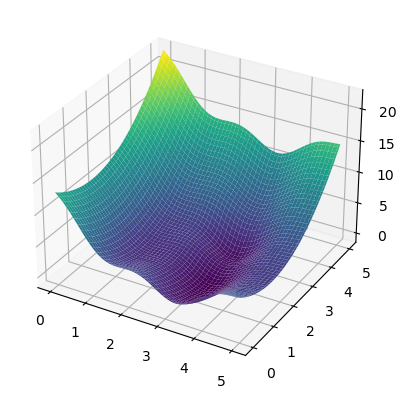

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Stopping search: Swarm best objective change less than 1e-08
Best solution of x (PSO) = (3.28, 1.5499)
Objective value for f(x) (PSO) = -1.0608
Best solution of x (GA) = (3.2693, 1.5531)
Objective value for f(x) (GA) = -1.0601


In [1]:
# ============================
# Metaheuristic optimisation
# ============================

"""
When analytical or classical iterative methods are unsuitable, heuristic and
metaheuristic optimisation methods provide an efficient alternative finding 
high-quality approximate solutions.

Metaheuristics operate at a higher level, guiding simpler heuristics to balance:
  - Exploration: broad search to avoid poor local minima
  - Exploitation: local refinement to improve solution quality

Examples include:
  - Simulated Annealing (SA), inspired by thermal annealing
  - Ant Colony Optimisation (ACO), based on pheromone-guided path finding

Particle Swarm Optimisation (PSO) is a population-based metaheuristic inspired
by flocking and schooling behaviour. Each candidate solution ("particle")
moves through the search space with a velocity influenced by:
  - its own best-known position (cognitive component)
  - the swarm’s global best position (social component)

The particle update equations are:
  v_i(t+1) = w v_i(t) + c1 r1 (p_i − x_i) + c2 r2 (g − x_i)
  x_i(t+1) = x_i(t) + v_i(t+1)
where w controls exploration–exploitation balance and r1, r2 ~ U(0,1).

Objective:
Minimise the non-convex function
  f(x, y) = (x − π)^2 + (y − π/2)^2
            + sin(3x + π/3)
            + sin(4y − π/4) exp(−[(x − 3)^2 + (y − 3)^2])
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================
# Objective function
# ============================

# Define the objective function and visualise its surface
def f(x, y):
    return (x-np.pi)**2 + (y-np.pi/2)**2 + np.sin(3*x+np.pi/3) \
           + np.sin(4*y-np.pi/4) * np.exp(-((x-3)**2 + (y-3)**2))

# Create a grid of evaluation points
X = np.linspace(0, 5, 100)
Y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Plot the objective surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
plt.show()

# ============================
# Particle Swarm Optimisation
# ============================

# Use PSO to locate the global minimum
!pip install pyswarm
from pyswarm import pso

# Search bounds for each design variable
lb = [-10, -10]
ub = [10, 10]

"""
Penalty Method
--------------
Constraints are enforced by augmenting the objective function:
    f_penalised(x) = f(x) + λ P(x)

P(x) = 0 for feasible solutions and increases quadratically with the magnitude
of constraint violations. This discourages infeasible solutions without
explicitly rejecting them, making the approach well-suited to metaheuristics.
"""

# Penalty function enforcing variable bounds
def penalty(x, penalty_coeff=1e4):
    p = 0.0

    if x[0] < -10:
        p += (-10 - x[0])**2
    if x[0] > 10:
        p += (x[0] - 10)**2
    if x[1] < -10:
        p += (-10 - x[1])**2
    if x[1] > 10:
        p += (x[1] - 10)**2

    return penalty_coeff * p

# Penalised objective function (vector form required by PSO)
def f_penalised(x):
    base = (x[0]-np.pi)**2 + (x[1]-np.pi/2)**2 \
           + np.sin(3*x[0]+np.pi/3) \
           + np.sin(4*x[1]-np.pi/4) * np.exp(-((x[0]-3)**2 + (x[1]-3)**2))
    return base + penalty(x)

# Run PSO
xopt, fopt = pso(f_penalised, lb, ub, maxiter=100, swarmsize=50)

print("Best solution of x (PSO) =", tuple(np.round(xopt, 4)))
print("Objective value for f(x) (PSO) =", round(fopt, 4))

# ============================
# Genetic Algorithm (GA)
# ============================

# Genetic Algorithms are population-based optimisers inspired by natural selection.
# Candidate solutions ("chromosomes") evolve via:
#   - selection
#   - crossover
#   - mutation
#
# GAs are flexible and well-suited to complex, noisy, or multi-modal landscapes.
# Note: pygad maximises the fitness function by default.

import pygad as ga

# Penalised fitness function for GA (must be maximised)
def f_penalised(ga_instance, sol, sol_idx):
    x = sol
    base = (x[0]-np.pi)**2 + (x[1]-np.pi/2)**2 \
           + np.sin(3*x[0]+np.pi/3) \
           + np.sin(4*x[1]-np.pi/4) * np.exp(-((x[0]-3)**2 + (x[1]-3)**2))
    return -(base + penalty(x))

# GA configuration
ga_instance = ga.GA(
    num_generations=1000,
    num_parents_mating=4,
    sol_per_pop=12,
    fitness_func=f_penalised,
    num_genes=2,
    init_range_low=lb,
    init_range_high=ub,
    parent_selection_type='rank',
    keep_elitism=1,
    gene_type=[float, float],
    crossover_type='single_point',
    mutation_type='random',
    mutation_num_genes=1
)

ga_instance.run()

# Extract and report best solution
sol, sol_fitness, sol_idx = ga_instance.best_solution()
sol = np.asarray(sol, dtype=float)

print("Best solution of x (GA) =", tuple(np.round(sol, 4)))
print("Objective value for f(x) (GA) =", round(-sol_fitness, 4))